# A/B テスト結果の分析

baseline（フィードバックA）と ours（フィードバックB）の比較結果を可視化します。

In [9]:
import json
import os
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from pathlib import Path
from collections import Counter

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


## 1. データの読み込み

In [10]:
# 公開スプレッドシートまたはローカルファイルから回答データを読み込み
SPREADSHEET_ID = os.getenv("SPREADSHEET_ID")
SPREADSHEET_ID = "1izdfY3hRavoOT1rJFX2kUW1u5hAdr09pGjJl-suszDc"
WORKSHEET_GID = os.getenv("WORKSHEET_GID", "0")  # シートのgid。未指定なら1枚目(0)

results_path = Path("results/abtest_results.jsonl")

def load_df_from_public_sheet() -> pd.DataFrame:
    """公開設定のスプレッドシートをCSVエクスポートで取得する"""
    if not SPREADSHEET_ID:
        raise ValueError("環境変数 SPREADSHEET_ID を設定してください。")

    gid = WORKSHEET_GID or "0"
    url = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/export?format=csv&gid={gid}"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    text = resp.content.decode("utf-8-sig", errors="replace")
    return pd.read_csv(io.StringIO(text))


df = None
load_errors = []

try:
    df = load_df_from_public_sheet()
    print(f"スプレッドシートから {len(df)} 行を読み込みました。")
except Exception as e:
    load_errors.append(e)
    print(f"スプレッドシート読み込みに失敗: {e}")

if df is None:
    if results_path.exists():
        df = pd.read_json(results_path, lines=True)
        print(f"ローカルファイルから {len(df)} 行を読み込みました。 ({results_path})")
    else:
        raise RuntimeError(f"データ取得に失敗しました: {load_errors}")


def to_bool(val):
    if isinstance(val, bool):
        return val
    if isinstance(val, str):
        return val.strip().lower() in ("true", "1", "t", "yes", "y")
    if isinstance(val, (int, float)):
        return val != 0
    return False


if "baseline_on_left" in df.columns:
    df["baseline_on_left"] = df["baseline_on_left"].apply(to_bool)

print(f"列一覧: {list(df.columns)}")
df.head()


スプレッドシートから 170 行を読み込みました。
列一覧: ['timestamp', 'user_id', 'item_index', 'source_userid', 'baseline_on_left', 'kyushu_student', 'info_course_taken', 'info_course_grade', 'accuracy', 'readability', 'persuasiveness', 'actionability', 'hallucination', 'usefulness', 'overall', 'comment']


,timestamp,user_id,item_index,source_userid,baseline_on_left,kyushu_student,info_course_taken,info_course_grade,accuracy,readability,persuasiveness,actionability,hallucination,usefulness,overall,comment
0,2025-12-12T00:13:28.655557,nishio,0,C-2022-1_U6,False,いいえ,いいえ,未回答,A が強く良い,A がやや良い,A が強く良い,A が強く良い,どちらとも言えない,A が強く良い,A が強く良い,NaN
1,2025-12-12T00:14:29.211497,nishio,1,C-2021-2_U115,True,いいえ,いいえ,未回答,B がやや良い,B がやや良い,B がやや良い,B がやや良い,どちらとも言えない,B がやや良い,B がやや良い,NaN
2,2025-12-12T00:17:02.480382,nishio,2,C-2021-1_U43,True,いいえ,いいえ,未回答,B がやや良い,B が強く良い,B がやや良い,B がやや良い,B がやや良い,B がやや良い,B が強く良い,NaN
3,2025-12-12T00:19:49.297296,nishio,3,C-2022-1_U92,False,いいえ,いいえ,未回答,A が強く良い,A がやや良い,A がやや良い,A がやや良い,A がやや良い,A が強く良い,A がやや良い,NaN
4,2025-12-12T00:20:43.078189,nishio,4,C-2021-2_U149,True,いいえ,いいえ,未回答,B がやや良い,B がやや良い,B がやや良い,B がやや良い,どちらとも言えない,B がやや良い,B がやや良い,NaN


## 2. 評価値を標準化（Baseline有利→正、Ours有利→負）

In [11]:
# RATING_SCALE のマッピング
# "A が強く良い", "A がやや良い", "どちらとも言えない", "B がやや良い", "B が強く良い"
rating_to_score = {
    "A が強く良い": 2,
    "A がやや良い": 1,
    "どちらとも言えない": 0,
    "B がやや良い": -1,
    "B が強く良い": -2,
}

# 評価項目
rating_fields = [
    "usefulness",
    "readability",
    "persuasiveness",
    "actionability",
    "hallucination",
    "overall",
]

# baseline_on_left を使って Baseline vs Ours のスコアに変換
# baseline_on_left=True のとき Baseline=A, False のとき Baseline=B なので、
# A側有利スコアに Baseline が A なら +1, B なら -1 を掛ける。
sign = df["baseline_on_left"].map({True: 1, False: -1})
for field in rating_fields:
    base_score = df[field].map(rating_to_score)
    df[f"{field}_score"] = base_score * sign

print("変換完了（正=Baseline有利、負=Ours有利）")
df[["usefulness", "usefulness_score"]].head()

変換完了（正=Baseline有利、負=Ours有利）


,usefulness,usefulness_score
0,A が強く良い,-2
1,B がやや良い,-1
2,B がやや良い,-1
3,A が強く良い,-2
4,B がやや良い,-1


## 3. 全体の勝敗集計

In [12]:
# 各フィールドごとの勝敗を集計
results_summary = {}

for field in rating_fields:
    score_col = f"{field}_score"

    a_wins = (df[score_col] > 0).sum()
    ties = (df[score_col] == 0).sum()
    b_wins = (df[score_col] < 0).sum()

    results_summary[field] = {
        "Baseline (A) 勝利": a_wins,
        "同程度": ties,
        "Ours (B) 勝利": b_wins,
    }

summary_df = pd.DataFrame(results_summary).T
print("\n=== 評価項目ごとの勝敗集計 ===")
print(summary_df)
print(f"\n総回答数: {len(df)}")


=== 評価項目ごとの勝敗集計 ===
                Baseline (A) 勝利  同程度  Ours (B) 勝利
usefulness                   72   23           75
readability                  62   31           77
persuasiveness               74   18           78
actionability                64   26           80
hallucination                48   58           64
overall                      70   23           77

総回答数: 170


## 4. 平均スコアの計算

In [13]:
# 各フィールドの平均スコアを計算（正=A有利、負=B有利）
avg_scores = {}
for field in rating_fields:
    score_col = f"{field}_score"
    avg_scores[field] = df[score_col].mean()

print("\n=== 平均スコア（正=A有利、負=B有利） ===")
for field, score in avg_scores.items():
    direction = "A有利" if score > 0 else "B有利" if score < 0 else "同程度"
    print(f"{field:20s}: {score:+.3f}  ({direction})")


=== 平均スコア（正=A有利、負=B有利） ===
usefulness          : -0.059  (B有利)
readability         : -0.141  (B有利)
persuasiveness      : +0.024  (A有利)
actionability       : -0.124  (B有利)
hallucination       : -0.129  (B有利)
overall             : -0.071  (B有利)


## 5. 棒グラフ：項目ごとの勝敗（積み上げ）

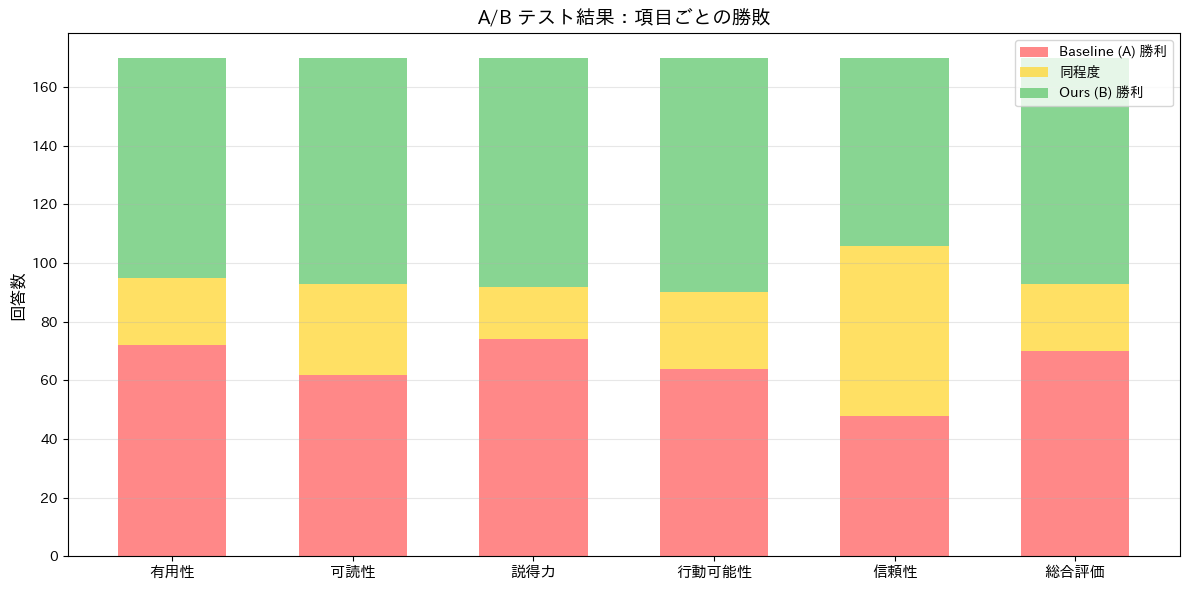

In [14]:
# 日本語ラベル
field_labels = {
    "usefulness": "有用性",
    "readability": "可読性",
    "persuasiveness": "説得力",
    "actionability": "行動可能性",
    "hallucination": "信頼性",
    "overall": "総合評価",
}

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(rating_fields))
width = 0.6

a_wins_list = [summary_df.loc[f, "Baseline (A) 勝利"] for f in rating_fields]
ties_list = [summary_df.loc[f, "同程度"] for f in rating_fields]
b_wins_list = [summary_df.loc[f, "Ours (B) 勝利"] for f in rating_fields]

ax.bar(x, a_wins_list, width, label="Baseline (A) 勝利", color="#FF6B6B", alpha=0.8)
ax.bar(x, ties_list, width, bottom=a_wins_list, label="同程度", color="#FFD93D", alpha=0.8)
ax.bar(x, b_wins_list, width, bottom=np.array(a_wins_list) + np.array(ties_list),
       label="Ours (B) 勝利", color="#6BCB77", alpha=0.8)

ax.set_ylabel("回答数", fontsize=12)
ax.set_title("A/B テスト結果：項目ごとの勝敗", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([field_labels[f] for f in rating_fields], fontsize=11)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("results/01_wins_by_field.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. 折れ線グラフ：平均スコアの比較

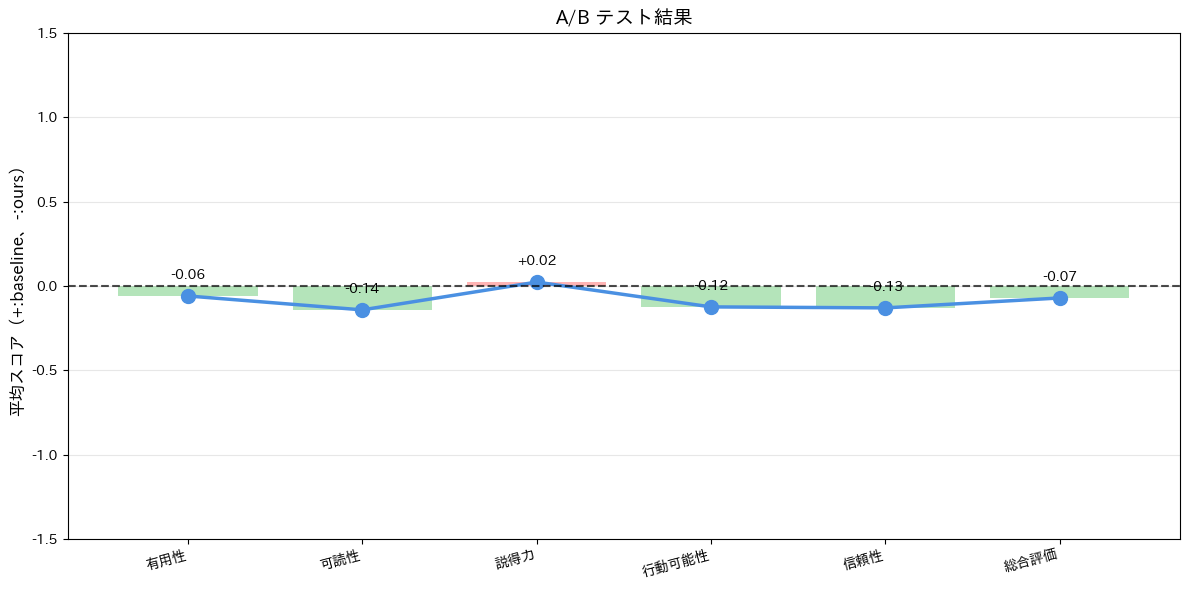

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

scores = [avg_scores[f] for f in rating_fields]
labels = [field_labels[f] for f in rating_fields]

colors = ["#FF6B6B" if s > 0 else "#6BCB77" if s < 0 else "#FFD93D" for s in scores]

ax.plot(labels, scores, marker="o", linewidth=2.5, markersize=10, color="#4A90E2")
ax.bar(labels, scores, alpha=0.5, color=colors)
ax.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

ax.set_ylabel("平均スコア（+:baseline、-:ours）", fontsize=12)
ax.set_title("A/B テスト結果", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# y軸範囲を調整
ax.set_ylim(-1.5, 1.5)

# スコア値を各点に表示
for i, (label, score) in enumerate(zip(labels, scores)):
    ax.text(i, score + 0.1, f"{score:+.2f}", ha="center", fontsize=10, fontweight="bold")

plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.savefig("results/02_average_scores.svg", dpi=300, bbox_inches="tight")
plt.show()

## 7. 全体の勝敗（総合評価のみ）

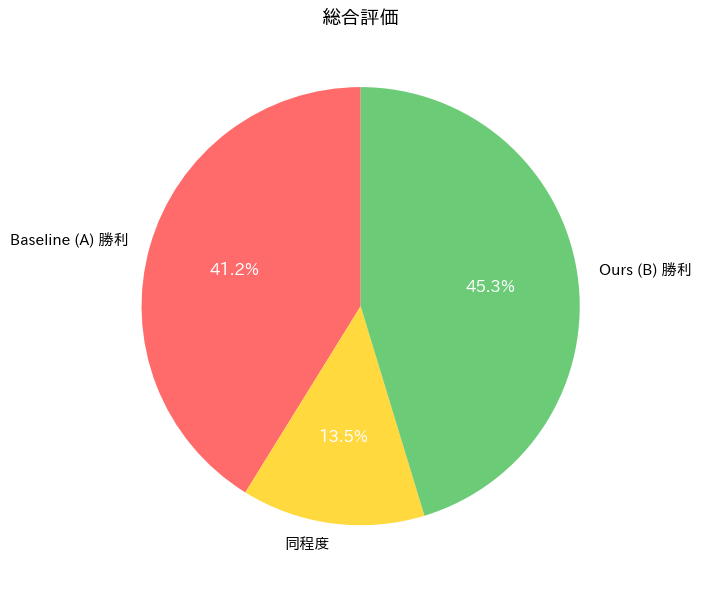

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

overall_data = summary_df.loc["overall"].values
labels = summary_df.loc["overall"].index
colors_pie = ["#FF6B6B", "#FFD93D", "#6BCB77"]

wedges, texts, autotexts = ax.pie(
    overall_data,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors_pie,
    startangle=90,
    textprops={"fontsize": 11}
)

# パーセンテージのテキストを太字に
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")
    autotext.set_fontsize(12)

ax.set_title("総合評価", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("results/03_overall_pie.svg", dpi=300, bbox_inches="tight")
plt.show()

## 8. 統計的有意性の簡易検定（符号検定）

In [17]:
from scipy import stats

print("\n=== 符号検定（統計的有意性） ===")
print("帰無仮説: A と B に差がない\n")

for field in rating_fields:
    score_col = f"{field}_score"
    # 同程度を除いて検定
    scores_nonzero = df[df[score_col] != 0][score_col].values

    if len(scores_nonzero) > 0:
        # 符号検定（2項検定）
        a_count = (scores_nonzero > 0).sum()
        n = len(scores_nonzero)
        p_value = stats.binomtest(a_count, n, 0.5, alternative="two-sided").pvalue

        significance = "*" if p_value < 0.05 else ""
        print(f"{field_labels[field]:10s}: p={p_value:.4f}  {significance}")


=== 符号検定（統計的有意性） ===
帰無仮説: A と B に差がない

有用性       : p=0.8690  
可読性       : p=0.2349  
説得力       : p=0.8078  
行動可能性     : p=0.2112  
信頼性       : p=0.1561  
総合評価      : p=0.6208  


## 9. 参加者属性別の分析

In [18]:
# 九州大学学生の有無別
print("\n=== 九州大学学生の有無別 ===")
if "kyushu_student" in df.columns:
    for group in df["kyushu_student"].unique():
        subset = df[df["kyushu_student"] == group]
        avg_score = subset["overall_score"].mean()
        print(f"{group}: n={len(subset)}, 平均スコア={avg_score:+.3f}")

# 情報科学受講経験別
print("\n=== 情報科学受講経験別 ===")
if "info_course_taken" in df.columns:
    for group in df["info_course_taken"].unique():
        subset = df[df["info_course_taken"] == group]
        avg_score = subset["overall_score"].mean()
        print(f"{group}: n={len(subset)}, 平均スコア={avg_score:+.3f}")


=== 九州大学学生の有無別 ===
いいえ: n=170, 平均スコア=-0.071

=== 情報科学受講経験別 ===
いいえ: n=158, 平均スコア=-0.044
はい: n=12, 平均スコア=-0.417


## 10. サマリーテーブルをCSVに保存

In [19]:
# 結果サマリーをCSVに保存
summary_df.to_csv("results/summary_wins.csv")

# 平均スコアをCSVに保存
avg_df = pd.DataFrame({
    "評価項目": [field_labels[f] for f in rating_fields],
    "平均スコア": [avg_scores[f] for f in rating_fields],
})
avg_df.to_csv("results/average_scores.csv", index=False)

print("✓ results/summary_wins.csv")
print("✓ results/average_scores.csv")
print("\n分析完了！")

✓ results/summary_wins.csv
✓ results/average_scores.csv

分析完了！
